# Zadanie 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import pandas as pd

In [2]:
def griewank(x):
    fr = 4000
    S = np.sum(x * x, axis = 1) / fr
    
    P = np.sqrt(range(1,x.shape[1] + 1)).reshape(1, -1)
    P = np.cos(x / P)
    P = np.prod(P, axis = 1)
    
    return S - P + 1

In [3]:
def rastrigin(x):
    n = x.shape[1]
    S = x * x - 10 * np.cos(np.pi * 2 * x)
    S = np.sum(S, axis = 1)
    return 10 * n + S

In [4]:
def rosenbrock(x):
    x_j = x[:, :-1]
    x_j1 = x[:, 1:]
    S = 100 * (x_j*x_j - x_j1) ** 2 + (x_j - 1) ** 2
    return np.sum(S, axis = 1)

In [5]:
def schwefel(x):
    alpha = 418.9829
    n = x.shape[1]
    S = x * np.sin(np.sqrt(abs(x)))
    return alpha * n - np.sum(S, axis = 1)

In [739]:
def sphere(x):
    S = np.sum(x * x, axis = 1)
    return S

In [1042]:
def mutate(xs, sigmas, K, domain):
    d = xs.shape[1]
    tau0 = K / np.sqrt(2 * np.sqrt(d))
    tau = K / np.sqrt(2 * d)
    
    eps_0 = np.random.normal(loc = 0, scale = tau0)
    eps_i = np.random.normal(loc = 0, scale = tau, size = sigmas.shape)
    mut_sigmas = sigmas * np.exp(eps_0 + eps_i)
    
    eps_i = np.random.normal(loc = 0, scale = sigmas, size = xs.shape)
    mut_xs = xs + eps_i
    #check if we are in domain its good to turn it of with constrained problems
    mut_xs[mut_xs < domain[0]] = domain[0]
    mut_xs[mut_xs > domain[1]] = domain[1]
    return mut_xs, mut_sigmas

def ES(F, domain, n, mu, lambd, it_num, K, method = 'mi+lambda', verbose = False, maximize = False): # method = 'mi+lambda' / 'mi,lambda'
    population_size = mu
    number_of_offspring = lambd
    low, high = domain
    
    #generating population
    current_xs = np.random.uniform(size = (population_size, n), high = domain[1], low = domain[0]) #* (high - low) + low
    current_sigmas = np.random.uniform(size = (population_size, n)) # np.ones(population_size, n)
    #objective_values = np.zeros(population_size)
    best_objective_value = np.Inf
    if maximize:
        best_objective_value = -np.Inf
    
    #evaluating objective function on current population
    #for i in range(population_size):
    objective_values = F(current_xs)
    #print(objective_values, objective_values.shape)
    costs = np.zeros(it_num)
    chromosomes = np.zeros((1, n))
    sigmas = np.zeros((1, n))
    for t in tqdm(range(it_num), disable = not verbose):
        
        # selecting the parent indices by the roulette wheel method
        fitness_values = objective_values.max() - objective_values
        if maximize:
            fitness_values = objective_values - objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(population_size) / population_size
            
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)
        
        children_xs = current_xs[parent_indices]
        children_sigmas = current_sigmas[parent_indices]
        
        # mutating the children population
        children_xs, children_sigmas = mutate(children_xs, children_sigmas, K, domain)
        
        #evaluating objective function on children population
        #children_objective_values = np.zeros(number_of_offspring)
        #for i in range(number_of_offspring):
        children_objective_values = F(children_xs)
        
        if method == 'mi+lambda':
            # replacing the current population by (Mu + Lambda) Replacement
            objective_values = np.hstack([objective_values, children_objective_values])
            current_xs = np.vstack([current_xs, children_xs])
            current_sigmas = np.vstack([current_sigmas, children_sigmas])
            
            I = np.argsort(objective_values)
    
            if maximize:
                I = np.flip(I)

            current_xs = current_xs[I[:population_size], :]
            current_sigmas = current_sigmas[I[:population_size], :]
            objective_values = objective_values[I[:population_size]]
            
        elif method == 'mi,lambda':
            # replacing the current population by (Mu, Lambda) Replacement

            I = np.argsort(children_objective_values)
            current_xs = children_xs[I[:population_size], :]
            current_sigmas = children_sigmas[I[:population_size], :]
            objective_values = children_objective_values[I[:population_size]]
        else:
            assert False
            
        # recording some statistics
        costs[t] = objective_values[0]
        chromosomes = np.vstack([chromosomes, current_xs[0, :]])
        sigmas = np.vstack([sigmas, current_sigmas[0, :]])
        if best_objective_value < objective_values[0] and maximize:
            best_objective_value = objective_values[0]
        if best_objective_value > objective_values[0] and not maximize:
            #print(chromosomes[-1], objective_values[0], F(current_xs), current_xs)
            best_objective_value = objective_values[0]
    return best_objective_value, costs, chromosomes[1:, :], sigmas[1:, :]
            

In [560]:
def find_best_K(F, domain, n):
    K_s = [0.01, 0.1, 0.3, 0.4, 0.5, 0.6, 0.9, 1.0, 2.0, 5.0]#, 10.0, 20.0, 50.0, 100.0]
    hist_mi_plus_lambda = {key:0 for key in K_s}
    hist_mi_coma_lambda = {key:0 for key in K_s}
    for i in tqdm(range(len(K_s))):
        k = K_s[i]
        for _ in range(10):
            res = ES(F, domain, n, 10000, 10000, 500, k, method = 'mi+lambda')
            hist_mi_plus_lambda[k] += res[0]
        for _ in range(10):
            res = ES(F, domain, n, 10000, 10000, 500, k, method = 'mi,lambda')
            hist_mi_coma_lambda[k] += res[0]
            
        hist_mi_plus_lambda[k] /= 10.0
        hist_mi_coma_lambda[k] /= 10.0
        
    return hist_mi_plus_lambda, hist_mi_coma_lambda

In [71]:
def k_statistics(h):
    h_x = np.array(list(h.keys()))
    h_y = np.array(list(h.values()))
    I = np.argsort(h_y)
    print(f'Best 3 K\'s: {h_x[I][:3]}, sorted K\'s:')
    df = pd.DataFrame(list(zip(h_x[I], h_y[I])), columns = ["K", 'Average min'])

    print(df)
    y_pos = np.arange(len(h_y))
    plt.figure(figsize = (15,5))
    plt.xlabel("K")
    plt.ylabel("Average min")
    #plt.ylim((0,3 * 1e-3))
    _ = plt.xticks(y_pos, labels = h_x)
    _ = plt.bar(y_pos, h_y, color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'tomato', 'sienna', 'olivedrab', 'mediumseagreen', 'teal', 'lightblue'])

In [314]:
def plot_score(d1, repl):
    fig, ax = plt.subplots(1,2, figsize = ((10,4)))
    ax[0].plot(d1[1])
    ax[1].plot(d1[3])
    ax[0].set_title(repl)
    ax[1].set_title(repl)
    ax[0].set_ylabel('func_value')
    ax[1].set_ylabel('sigmas_value')
    print(f'{repl} best_score:{d1[0]}')

In [309]:
def plot_3d(func, steps, domain1, domain2):
    x = np.linspace(domain1[0], domain1[1], 50)
    y = np.linspace(domain2[0], domain2[1], 50)
    X, Y = np.meshgrid(x, y)
    args = np.hstack([X.ravel().reshape(-1, 1),Y.ravel().reshape(-1, 1)])
    Z = func(args).reshape(-1,50)
    
    fig = plt.figure(figsize = (12,7))
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=2, cmap='plasma')
    #xs = steps[:, 0].ravel()
    #ys = steps[:, 1].ravel()
    #zs = func(steps)

    #ax.scatter(xs, ys, zs, marker='o', color = 'red', alpha = 1.0)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(35, 230)

In [347]:
#try to find K's
domain = (-600, 600)
h1, h2 = find_best_K(griewank, domain, 50)

Best 3 K's: [1.  0.9 2. ], sorted K's:
      K  Average min
0  1.00    15.303726
1  0.90    36.727799
2  2.00    36.948971
3  0.60    44.277823
4  0.40    47.296526
5  0.50    50.374123
6  0.30    63.161381
7  5.00    81.495058
8  0.10   418.881335
9  0.01   470.776606


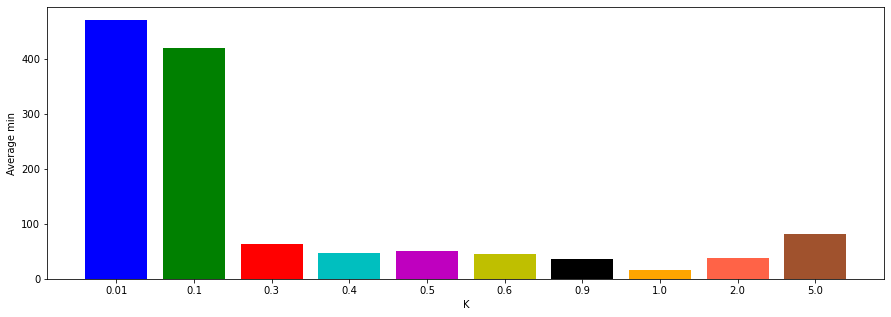

In [348]:
k_statistics(h1) #mi + lambda

Best 3 K's: [0.5 0.6 0.3], sorted K's:
      K  Average min
0  0.50   335.536161
1  0.60   411.248240
2  0.30   431.357706
3  1.00   446.144973
4  0.90   468.382514
5  0.40   517.064801
6  2.00   575.560084
7  0.10   590.391318
8  0.01   604.724749
9  5.00   680.316777


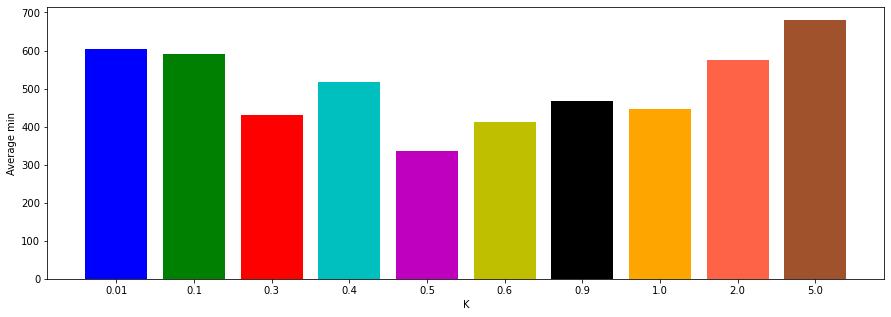

In [349]:
k_statistics(h2) # mi,lambda

## Rosenbrock
Minimum : 0 at x= [1,1,...,1]

### visualisation n = 2

In [709]:
domain = (-5, 10)
ros_1_2 = ES(rosenbrock, domain, 2, 10000, 10000, 1000, 1, method = 'mi+lambda', verbose = True)
ros_2_2 = ES(rosenbrock, domain, 2, 10000, 10000, 1000, 0.5, method = 'mi,lambda', verbose = True)

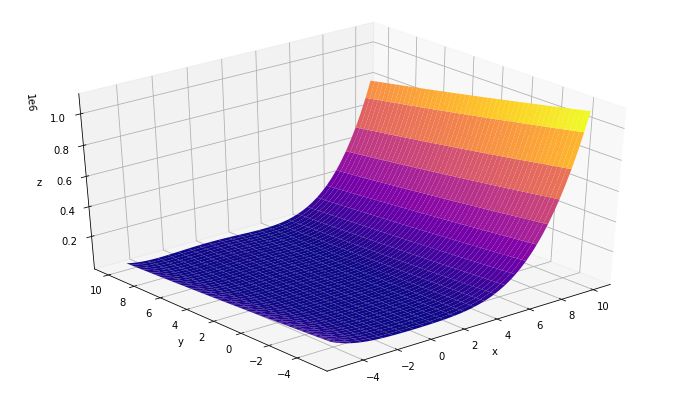

In [710]:
plot_3d(rosenbrock, ros_1_2[2], (-5, 10), (-5, 10))#(-1.5, 2.0), (-0.5, 3.0))

In [1126]:
domain = (-5, 10)
ros_1_10 = ES(rosenbrock, domain, 10, 10000, 10000, 1000, 1, method = 'mi+lambda', verbose = True)

MU+LAMBDA, n = 2 best_score:0.08367295004494174


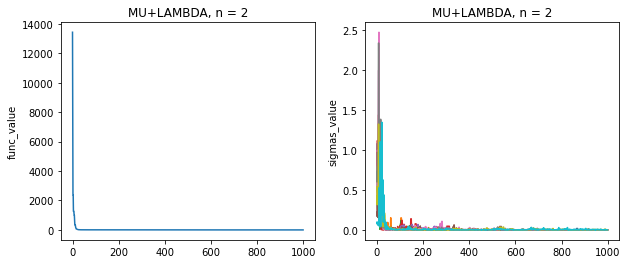

In [1127]:
plot_score(ros_1_10, 'MU+LAMBDA, n = 10')

MU+LAMBDA, n = 2 best_score:0.0
MU,LAMBDA, n = 2 best_score:4.4788711857440255e-05


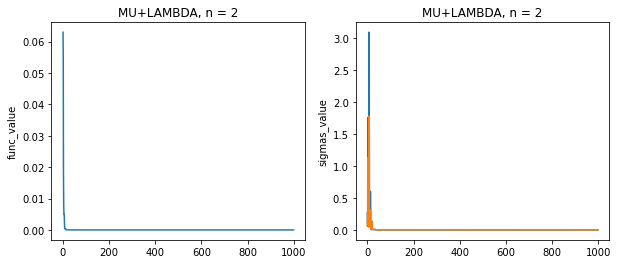

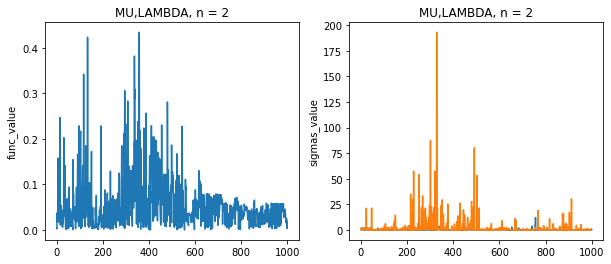

In [711]:
plot_score(ros_1_2, 'MU+LAMBDA, n = 2')
plot_score(ros_2_2, 'MU,LAMBDA, n = 2')

In [1014]:
domain = (-5, 10)
ros_1_50 = ES(rosenbrock, domain, 50, 3000, 4000, 1000, 1, method = 'mi+lambda', verbose = True)
ros_2_50 = ES(rosenbrock, domain, 50, 3000, 4000, 1000, 0.5, method = 'mi,lambda', verbose = True)

MU+LAMBDA, n = 50 best_score:356.5386952179011
MU,LAMBDA, n = 50 best_score:251137.87625997438


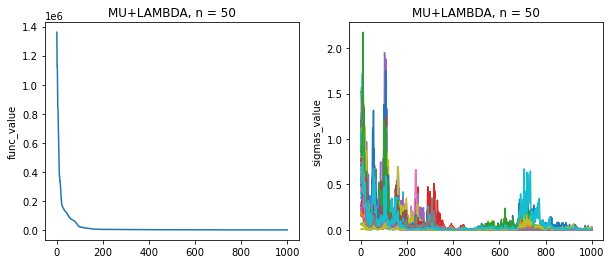

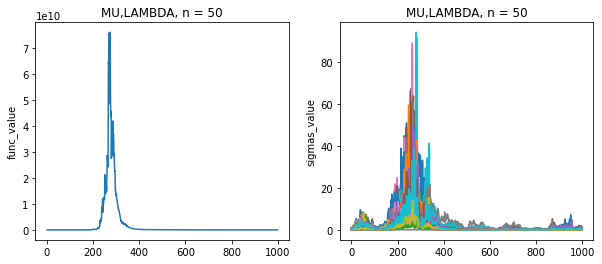

In [1015]:
plot_score(ros_1_50, 'MU+LAMBDA, n = 50')
plot_score(ros_2_50, 'MU,LAMBDA, n = 50')

In [1016]:
domain = (-5, 10)
ros_1_100 = ES(rosenbrock, domain, 100, 3000, 4000, 1000, 1, method = 'mi+lambda', verbose = True)
ros_2_100 = ES(rosenbrock, domain, 100, 3000, 4000, 1000, 0.5, method = 'mi,lambda', verbose = True)

MU+LAMBDA, n = 100 best_score:164511.40573662697
MU,LAMBDA, n = 100 best_score:657284.1650886403


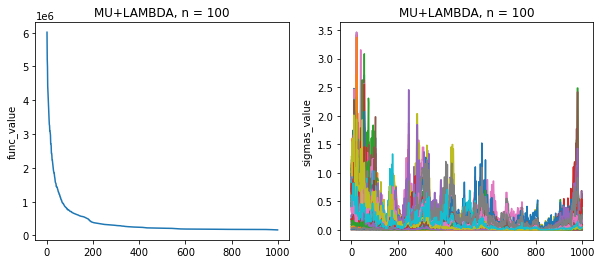

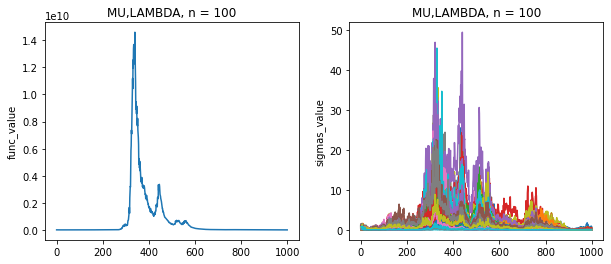

In [1017]:
plot_score(ros_1_100, 'MU+LAMBDA, n = 100')
plot_score(ros_2_100, 'MU,LAMBDA, n = 100')

In [1018]:
domain = (-5, 10)
ros_1_200 = ES(rosenbrock, domain, 200, 3000, 4000, 1000, 1, method = 'mi+lambda', verbose = True)

MU+LAMBDA, n = 200 best_score:410370.974338805


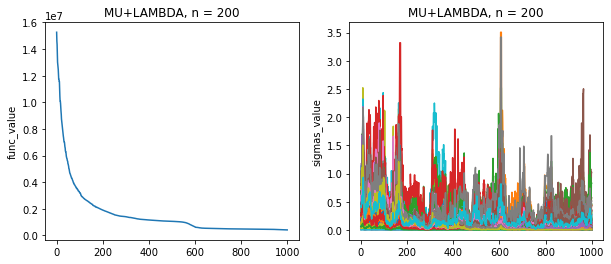

In [1019]:
plot_score(ros_1_200, 'MU+LAMBDA, n = 200')

## Griewank
Minimum 0 at [0,0,...,0]

### visualisation n = 2

In [718]:
domain = (-600, 600)
grie_1_2 = ES(griewank, domain, 2, 10000, 10000, 1000, 1, method = 'mi+lambda')
grie_2_2 = ES(griewank, domain, 2, 10000, 10000, 1000, 0.5, method = 'mi,lambda')

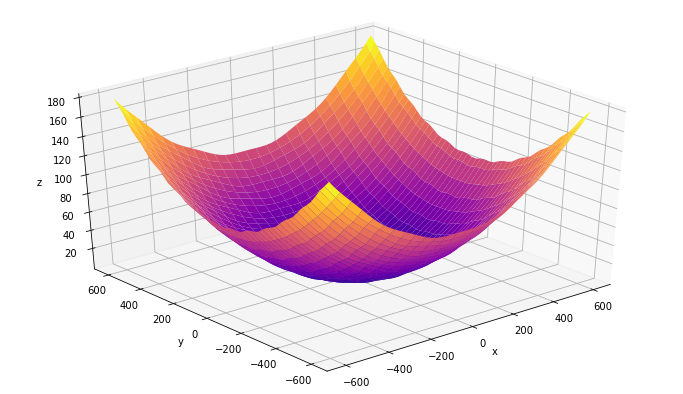

In [719]:
plot_3d(griewank, grie_1_2[2], domain, domain)

MI+LAMBDA best_score:0.019719489248184785
MI,LAMBDA best_score:0.0027392652992790367


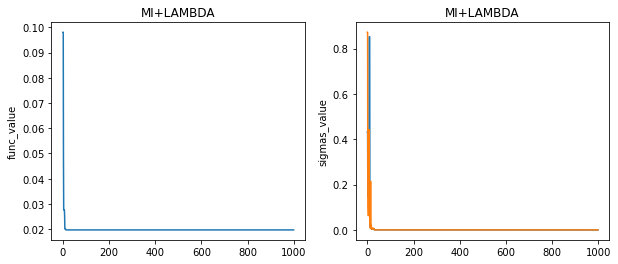

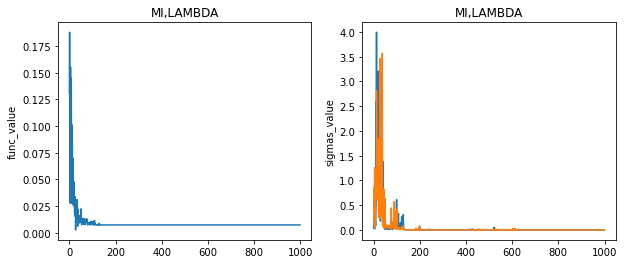

In [720]:
plot_score(grie_1_2, 'MI+LAMBDA')
plot_score(grie_2_2, 'MI,LAMBDA')

In [1007]:
domain = (-600, 600)
grie_1_50 = ES(griewank, domain, 50, 3000, 4000, 1000, 1.0, method = 'mi+lambda', verbose = True)
grie_2_50 = ES(griewank, domain, 50, 2000, 5000, 1000, 0.5, method = 'mi,lambda', verbose = True)

MI+LAMBDA best_score:1.8240884205813694
MI,LAMBDA best_score:62.69230700973982


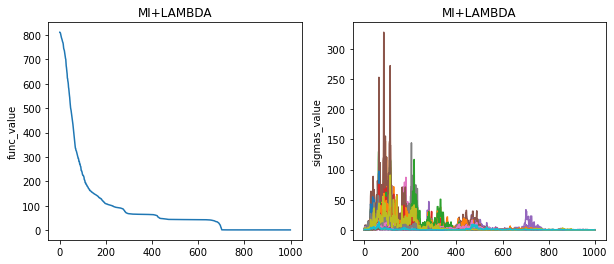

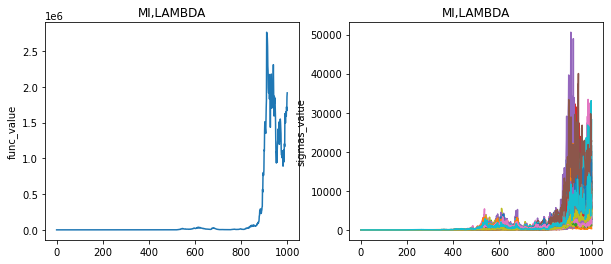

In [1008]:
plot_score(grie_1_50, 'MI+LAMBDA')
plot_score(grie_2_50, 'MI,LAMBDA')

In [1128]:
domain = (-600, 600)
grie_1_100 = ES(griewank, domain, 100, 3000, 4000, 4000, 1.0, method = 'mi+lambda', verbose = True)
#grie_2_100 = ES(griewank, domain, 100, 3000, 4000, 1000, 0.5, method = 'mi,lambda', verbose = True)

MI+LAMBDA best_score:47.49396123047662


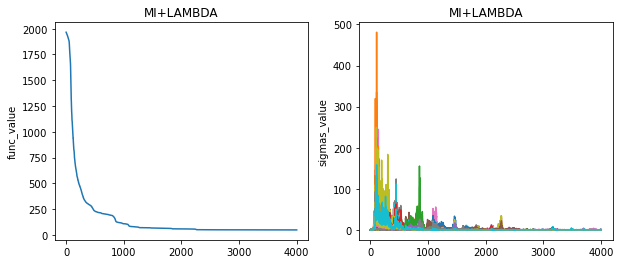

In [1129]:
plot_score(grie_1_100, 'MI+LAMBDA')
#plot_score(grie_2_100, 'MI,LAMBDA')

In [1012]:
domain = (-600, 600)
grie_1_200 = ES(griewank, domain, 200, 3000, 4000, 1000, 1.0, method = 'mi+lambda', verbose = True)

MI+LAMBDA best_score:649.3949533450494


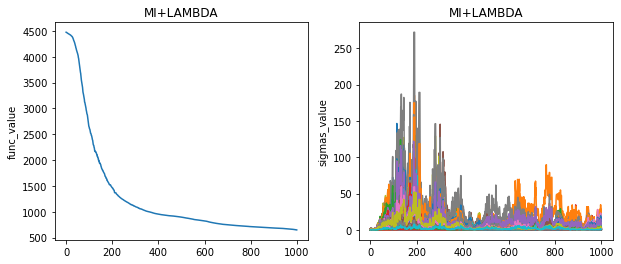

In [1013]:
plot_score(grie_1_200, 'MI+LAMBDA')

## Schwefel
Minimum 0 at [1,1,...,1]

In [727]:
domain = (-500, 500)
schwe_1_2 = ES(schwefel, domain, 2, 10000, 10000, 1000, 1, method = 'mi+lambda')
schwe_2_2 = ES(schwefel, domain, 2, 10000, 10000, 1000, 0.5, method = 'mi,lambda')

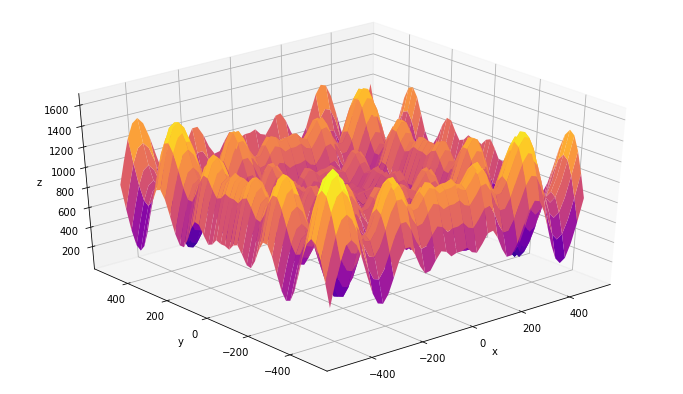

In [728]:
plot_3d(schwefel, schwe_1_2[2], domain, domain)

MI+LAMBDA best_score:2.5455132345086895e-05
MI,LAMBDA best_score:2.546070425069047e-05


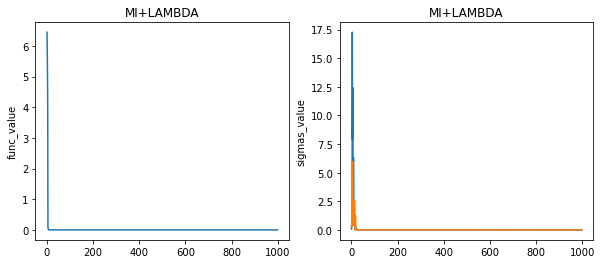

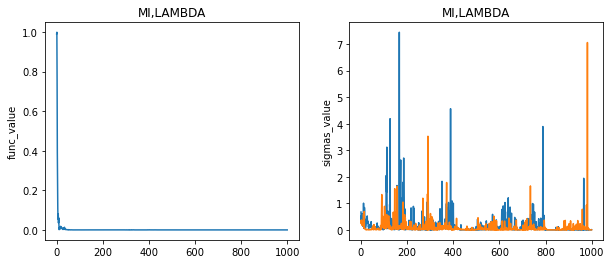

In [729]:
plot_score(schwe_1_2, 'MI+LAMBDA')
plot_score(schwe_2_2, 'MI,LAMBDA')

In [1020]:
domain = (-500, 500)
schwe_1_50 = ES(schwefel, domain, 50, 2000, 6000, 1000, 1, method = 'mi+lambda')
schwe_2_50 = ES(schwefel, domain, 50, 2000, 6000, 1000, 0.5, method = 'mi,lambda')

MI+LAMBDA best_score:8319.503152009398
MI,LAMBDA best_score:-12567.462309455965


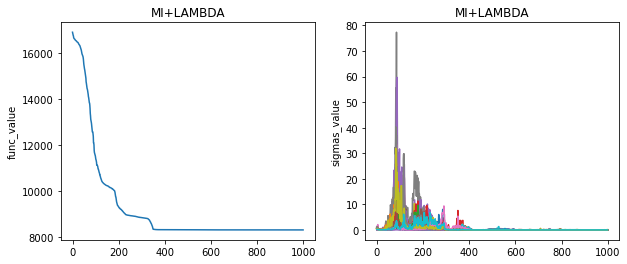

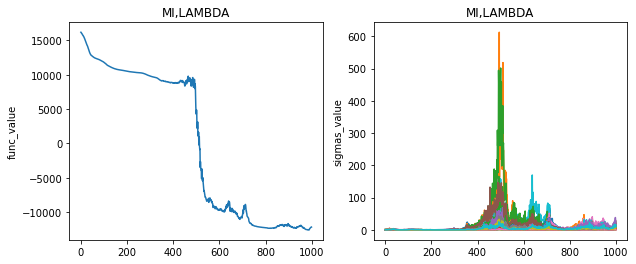

In [1021]:
plot_score(schwe_1_50, 'MI+LAMBDA')
plot_score(schwe_2_50, 'MI,LAMBDA')

In [1022]:
domain = (-500, 500)
schwe_1_100 = ES(schwefel, domain, 100, 2000, 6000, 1000, 1, method = 'mi+lambda', verbose = True)

MI+LAMBDA best_score:17915.258970769934


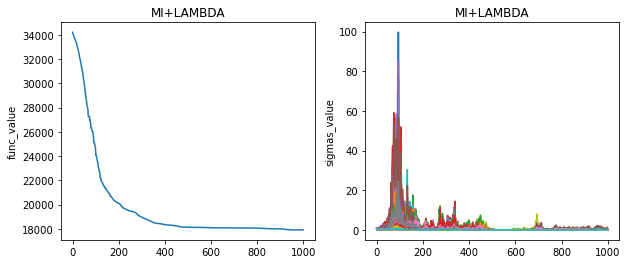

In [1023]:
plot_score(schwe_1_100, 'MI+LAMBDA')

In [1024]:
domain = (-500, 500)
schwe_1_200 = ES(schwefel, domain, 200, 2000, 6000, 1000, 1, method = 'mi+lambda', verbose = True)

MI+LAMBDA best_score:34773.88797523048


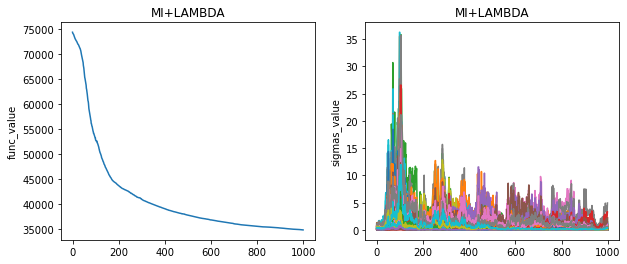

In [1025]:
plot_score(schwe_1_200, 'MI+LAMBDA')

## Sphere
Minimum: 0 at [0,0,...,1]

In [740]:
domain = (-5.12, 5.12)
sph_1_2 = ES(sphere, domain, 2, 10000, 10000, 1000, 1, method = 'mi+lambda')
sph_2_2 = ES(sphere, domain, 2, 10000, 10000, 1000, 0.5, method = 'mi,lambda')

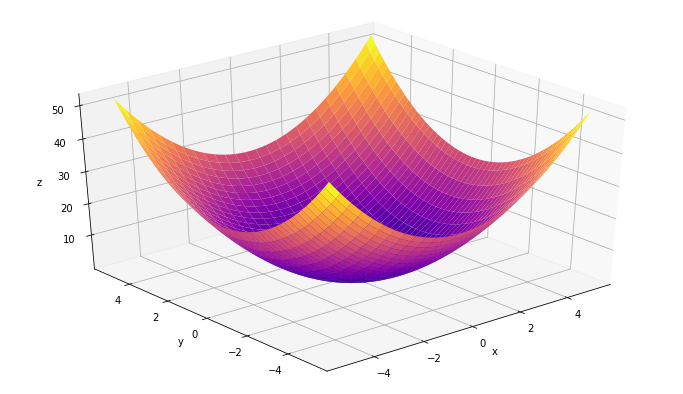

In [741]:
plot_3d(sphere, sph_1_2[2], domain, domain)

MI+LAMBDA best_score:1.3575197115715259e-258
MI,LAMBDA best_score:2.904595456585887e-13


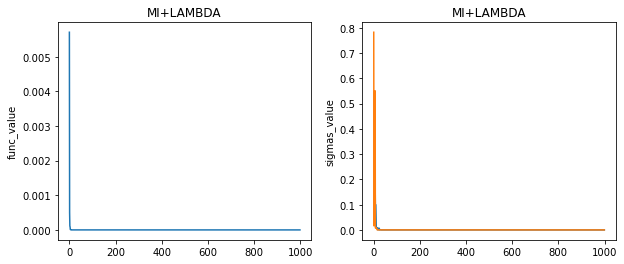

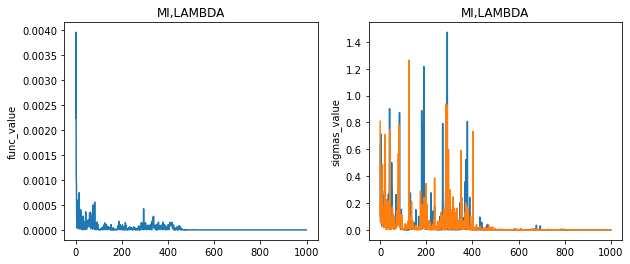

In [742]:
plot_score(sph_1_2, 'MI+LAMBDA')
plot_score(sph_2_2, 'MI,LAMBDA')

In [1026]:
domain = (-5.12, 5.12)
sph_1_50 = ES(sphere, domain, 50, 2000, 6000, 1000, 1, method = 'mi+lambda')

MI+LAMBDA best_score:0.6280621770164594


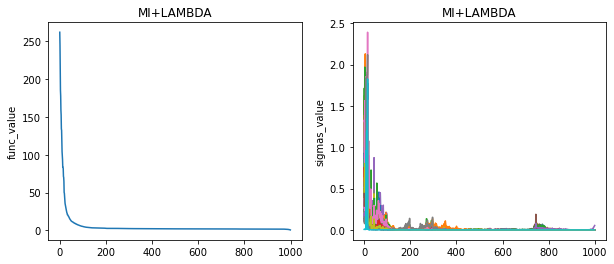

In [1027]:
plot_score(sph_1_50, 'MI+LAMBDA')

In [1028]:
domain = (-5.12, 5.12)
sph_1_100 = ES(sphere, domain, 100, 2000, 6000, 1000, 1, method = 'mi+lambda', verbose = True)

MI+LAMBDA best_score:46.61643573293997


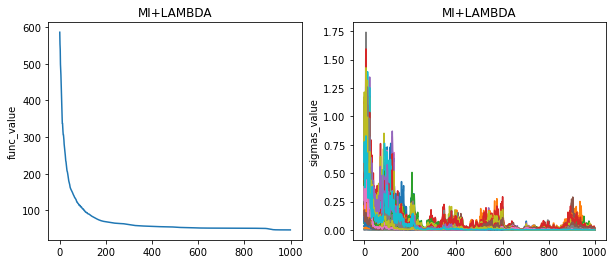

In [1029]:
plot_score(sph_1_100, 'MI+LAMBDA')

In [1030]:
domain = (-5.12, 5.12)
sph_1_200 = ES(sphere, domain, 200, 2000, 6000, 1000, 1, method = 'mi+lambda', verbose = True)

MI+LAMBDA best_score:99.2046815253662


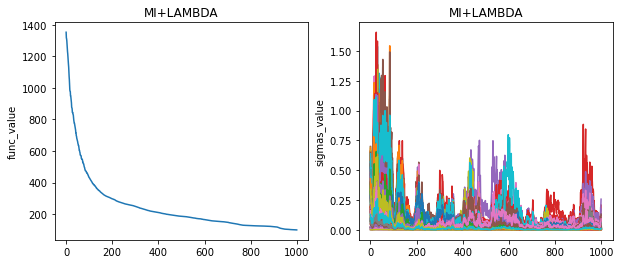

In [1031]:
plot_score(sph_1_200, 'MI+LAMBDA')

## Rastrigin
Minimum: 0 at [0,0,...,1]

In [1032]:
domain = (-5.12, 5.12)
rast_1_2 = ES(rastrigin, domain, 2, 2000, 6000, 1000, 1, method = 'mi+lambda')
rast_2_2 = ES(rastrigin, domain, 2, 2000, 6000, 1000, 0.5, method = 'mi,lambda')

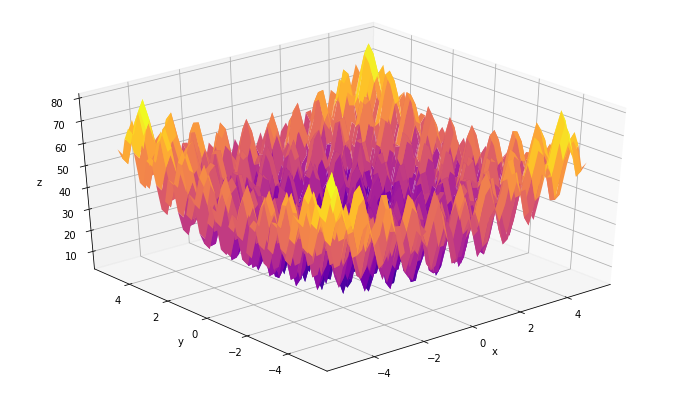

In [1033]:
plot_3d(rastrigin, rast_1_2[2], domain, domain)

MI+LAMBDA best_score:0.0
MI,LAMBDA best_score:0.0


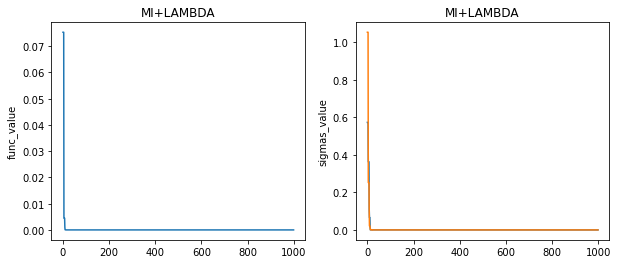

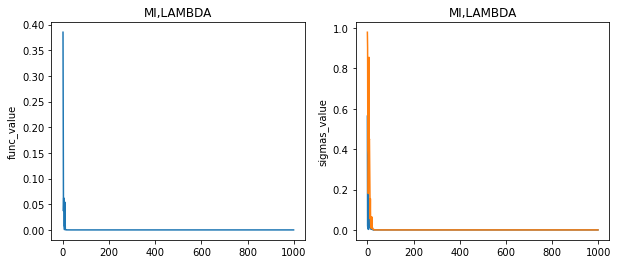

In [1034]:
plot_score(rast_1_2, 'MI+LAMBDA')
plot_score(rast_2_2, 'MI,LAMBDA')

In [1035]:
domain = (-5.12, 5.12)
rast_1_50 = ES(rastrigin, domain, 50, 2000, 6000, 1000, 1, method = 'mi+lambda')

MI+LAMBDA best_score:171.13434989224345


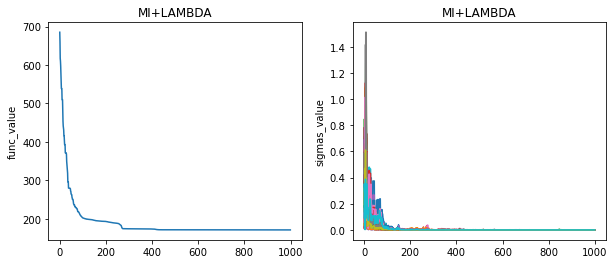

In [1036]:
plot_score(rast_1_50, 'MI+LAMBDA')

In [1037]:
domain = (-5.12, 5.12)
rast_1_100 = ES(rastrigin, domain, 100, 2000, 6000, 1000, 1, method = 'mi+lambda', verbose = True)

MI+LAMBDA best_score:526.0210766052056


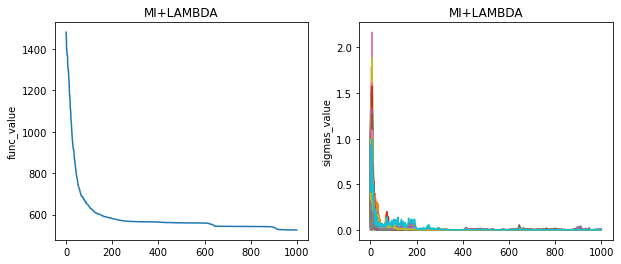

In [1038]:
plot_score(rast_1_100, 'MI+LAMBDA')

In [1039]:
domain = (-5.12, 5.12)
rast_1_200 = ES(rastrigin, domain, 200, 2000, 6000, 1000, 1, method = 'mi+lambda', verbose = True)

MI+LAMBDA best_score:1383.0138106557313


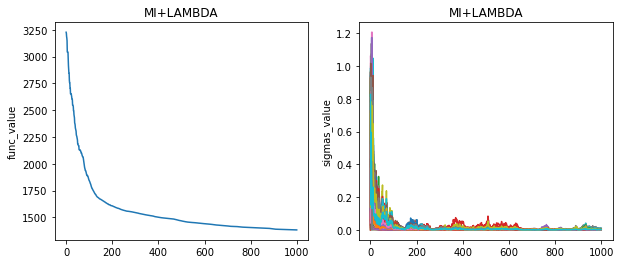

In [1040]:
plot_score(rast_1_200, 'MI+LAMBDA')

# Zadanie 2

In [ ]:
def G2(x, p = 1):
    n = x.shape[1]
    S = - (n ** (n/2)) * np.prod(x, axis = 1)
    eps = np.zeros(S.shape) + epsilon
    err = np.sum(x * x, axis = 1) - 1
    S[eps < abs(err)] += penalty * p
    return S
def errg3(x): #func to check error of 1 point
    return (np.sum(x * x, axis = 1) - 1)[0]

In [678]:
def G3(x, p = 1):
    n = x.shape[1]
    S = - (n ** (n/2)) * np.prod(x, axis = 1)
    eps = np.zeros(S.shape) + epsilon
    err = np.sum(x * x, axis = 1) - 1
    S[eps < abs(err)] += penalty * p
    return S
def errg3(x): #func to check error of 1 point
    return (np.sum(x * x, axis = 1) - 1)[0]

In [575]:
def G6(x , p = 1):
    S = (x[:, 0] - 10) ** 3 + (x[:, 1] - 20) ** 3
    eps = np.zeros(S.shape) + epsilon
    err1 = (x[:, 0] - 5) ** 2 + (x[:, 1] - 5) ** 2 + 100
    err2 = (x[:, 0] - 6) ** 2 + (x[:, 1] - 5) ** 2 - 82.81
    S[eps < err1] += penalty * p
    S[eps < err2] += penalty * p
    return S
def errg6(x): #func to check error of 1 point
    return ((x[:, 0] - 5) ** 2 + (x[:, 1] - 5) ** 2 + 100)[0],\
            ((x[:, 0] - 6) ** 2 + (x[:, 1] - 5) ** 2 - 82.81)[0]

In [703]:
def G7(x, p = 1):
    S = x[:, 0]**2 + x[:, 1]**2 + x[:, 0]*x[:, 1] - 14*x[:, 0] - 16*x[:, 1]+(x[:, 2]-10)**2+\
    4*(x[:,3]-5)**2+(x[:,4]-3)**2+2*(x[:,5]-1)**2+5*x[:,6]**2+\
    7*(x[:,7]-11)**2+2*(x[:,8]-10)**2+(x[:,9]-7)**2+45
    eps = np.zeros(S.shape) + epsilon
    err1 = 4*x[:,0]+5*x[:,1]-3*x[:,6]+9*x[:,7]-105
    err2 = 10*x[:,0]-8*x[:,1]-17*x[:,6]+2*x[:,7]  
    err3 = -8*x[:,0]+2*x[:,1]+5*x[:,8]-2*x[:,9]-12
    err4 = 3*(x[:,0]-2)**2+4*(x[:,1]-3)**2+2*x[:,2]**2-7*x[:,3]-120   
    err5 = 5*x[:,0]**2+8*x[:,1]+(x[:,2]-6)**2-2*x[:,3]-40
    err6 = 0.5*(x[:,0]-8)**2+2*(x[:,1]-4)**2+3*x[:,4]**2-x[:,5]-30
    err7 = x[:,0]**2+2*(x[:,1]-2)**2-2*x[:,0]*x[:,1]+14*x[:,4]-6*x[:,5]     
    err8 = -3*x[:,0]+6*x[:,1]+12*(x[:,8]-8)**2-7*x[:,9]
    S[eps < err1] += penalty * p
    S[eps < err2] += penalty * p
    S[eps < err3] += penalty * p
    S[eps < err4] += penalty * p
    S[eps < err5] += penalty * p
    S[eps < err6] += penalty * p
    S[eps < err7] += penalty * p
    S[eps < err8] += penalty * p
    return S
def errg7(x): #func to check error of 1 point
    return (4*x[:,0]+5*x[:,1]-3*x[:,6]+9*x[:,7]-105)[0],\
        (10*x[:,0]-8*x[:,1]-17*x[:,6]+2*x[:,7])[0],\
    (-8*x[:,0]+2*x[:,1]+5*x[:,8]-2*x[:,9]-12)[0],\
    (3*(x[:,0]-2)**2+4*(x[:,1]-3)**2+2*x[:,2]**2-7*x[:,3]-120)[0],\
    (5*x[:,0]**2+8*x[:,1]+(x[:,2]-6)**2-2*x[:,3]-40)[0],\
    (0.5*(x[:,0]-8)**2+2*(x[:,1]-4)**2+3*x[:,4]**2-x[:,5]-30)[0],\
    (x[:,0]**2+2*(x[:,1]-2)**2-2*x[:,0]*x[:,1]+14*x[:,4]-6*x[:,5])[0],\
    (-3*x[:,0]+6*x[:,1]+12*(x[:,8]-8)**2-7*x[:,9])[0]

In [612]:
def G8(x, p = 1):
    S = - np.sin(2 * np.pi * x[:, 0]) ** 3 * np.sin(2 * np.pi * x[:, 1]) / (x[:, 0] ** 3 * (x[:, 0] + x[:, 1]) + epsilon)
    err1 = x[:, 0] ** 2 - x[:, 1] + 1
    err2 = 1 - x[:, 0] + (x[:, 1] - 4) ** 2
    eps = np.zeros(S.shape) + epsilon
    S[eps < err1] += penalty * p
    S[eps < err2] += penalty * p
    return S
def errg8(x): #func to check error of 1 point
    return (x[:, 0] ** 2 - x[:, 1] + 1)[0],\
            (1 - x[:, 0] + (x[:, 1] - 4) ** 2)[0]

In [806]:
def G9(x, p = 1):
    S = (x[:,0]-10)**2+5*(x[:,1]-12)**2+x[:,2]**4+3*(x[:,3]-11)**2+\
    10*x[:,4]**6+7*x[:,5]**2+x[:,6]**4-4*x[:,5]*x[:,6]-10*x[:,5]-8*x[:,6]
    v1 = 2*x[:,0]**2
    v2 = x[:,1]**2
    eps = np.zeros(S.shape) + epsilon
    err1 = v1+3*v2**2+x[:,2]+4*x[:,3]**2+5*x[:,4]-127
    err2 = 7*x[:,0]+3*x[:,1]+10*x[:,2]**2+x[:,3]-x[:,4]-282
    err3 = 23*x[:,0]+v2+6*x[:,5]**2-8*x[:,6]-196
    err4 = 2*v1+v2-3*x[:,0]*x[:,1]+2*x[:,2]**2+5*x[:,5]-11*x[:,6]
    S[eps < err1] += penalty * p
    S[eps < err2] += penalty * p
    S[eps < err3] += penalty * p
    S[eps < err4] += penalty * p
    return S
def errg9(x): #func to check error of 1 point
    v1 = 2*x[:,1]**2
    v2 = x[:,1]**2
    err1 = v1+3*v2**2+x[:,2]+4*x[:,3]**2+5*x[:,4]-127
    err2 = 7*x[:,0]+3*x[:,1]+10*x[:,2]**2+x[:,3]-x[:,4]-282
    err3 = 23*x[:,0]+v2+6*x[:,5]**2-8*x[:,6]-196
    err4 = 2*v1+v2-3*x[:,0]*x[:,1]+2*x[:,2]**2+5*x[:,5]-11*x[:,6]
    return err1[0], err2[0], err3[0], err4[0]

In [638]:
def G11(x, p = 1): # x1^2 + x2^2 - 2x2 + 1
    S = np.sum(x * x, axis = 1) - 2 * x[:, 1] + 1
    eps = np.zeros(S.shape) + epsilon
    err = x[:, 1] - x[:, 0] ** 2
    S[eps < abs(err)] += penalty * p
    return S
def errg11(x): #func to check error of 1 point
    return (x[:, 1] - x[:, 0] ** 2)[0]

In [571]:
def G13(x):
    S = np.exp(np.prod(x, axis = 1))
    err1 = x[:,0] ** 2 + x[:,1] ** 2 + x[:,2] ** 2 +x[:,3] ** 2 + x[:,4] ** 2  - 10
    err2 = x[:, 1] * x[:, 2] - 5 * x[:, 3] * x[:, 4]
    err3 = x[:,0] ** 3 + x[:,1] ** 3 + 1
    eps = np.zeros(S.shape) + epsilon
    S[eps < abs(err1)] += penalty
    S[eps < abs(err2)] += penalty
    S[eps < abs(err3)] += penalty
    return S
def errg13(x): #func to check error of 1 point
    return (x[:,0] ** 2 + x[:,1] ** 2 + x[:,2] ** 2 +x[:,3] ** 2 + x[:,4] ** 2  - 10)[0],\
            (x[:, 1] * x[:, 2] - 5 * x[:, 3] * x[:, 4])[0],\
            (x[:,0] ** 3 + x[:,1] ** 3 + 1)[0]

In [814]:
def show_res(data, F, F_err, s = 1):
    costs = data[1]
    I = np.argsort(costs)
    print(f'Found minima: {data[2][I][0]}')
    print(f'Constraints: {F_err(data[2][I][0].reshape(1, -1))}')
    print(f'Value of this point: {s * F(data[2][I][0].reshape(1, -1), p = 0)[0]}')

In [899]:
penalty = 1e4
epsilon = 1e-4

# G3, n = 10, 30
The global minima: x* =  (1/n0.5, …, 1/n0.5), f(x*) = 1.

In [837]:
penalty = 1e10
epsilon = 1e-3
domain = (0, 1)
g3_10 = ES(G3, domain, 10, 10000, 10000, 2000, 0.9, verbose = True)

MI+LAMBDA best_score:-0.996033522586402
Found minima: [0.31411717 0.31297239 0.31401265 0.34474162 0.31391773 0.3132208
 0.31403741 0.30963449 0.31379387 0.31195632]
Constraints: 0.0009999987979381064
Value of this point: 0.996033522586402


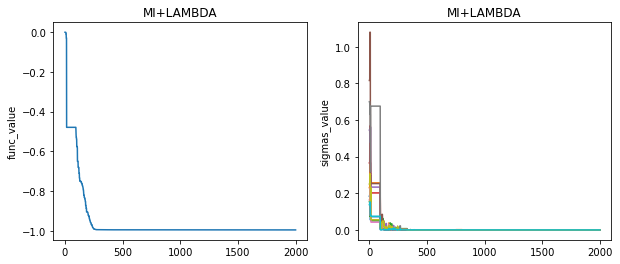

In [838]:
plot_score(g3_10, 'MI+LAMBDA')
show_res(g3_10, G3, errg3, s = -1)

In [987]:
penalty = 1e+22
epsilon = 3.8
domain = (0, 1)
g3_30 = ES(G3, domain, 30, 10000, 10000, 500, 0.9, verbose = True)

MI+LAMBDA best_score:-22639.42231613857
Found minima: [0.3195716  0.29253758 0.24976896 0.25925205 0.35738435 0.35995777
 0.00459202 0.05130099 0.76909272 0.42643232 0.23824192 0.33294805
 0.63584074 0.23864861 0.12938448 0.14532118 0.22284426 0.5138318
 0.13853595 0.28362995 0.50198156 0.53778505 0.05582995 0.54641015
 0.58928134 0.78558502 0.30409352 0.39930931 0.32531568 0.17100956]
Constraints: 3.62490518330503
Value of this point: 22639.42231613857


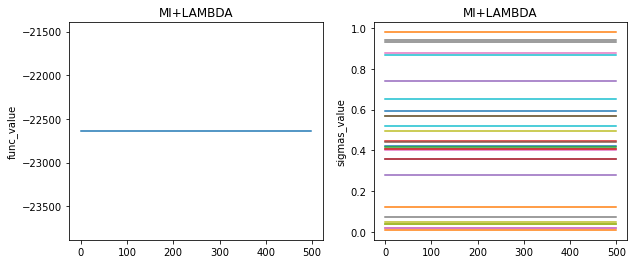

In [988]:
plot_score(g3_30, 'MI+LAMBDA')
show_res(g3_30, G3, errg3, s = -1)

# G7, n = 10
The global minima: x*=(2.171996, 2.363683, 8.773926, 5.095984, 0.9906548, 1.430574,1.321644, 9.828726, 8.280092, 8.375927),
f(x*) = 24.3062091.

In [944]:
penalty = 1e5
epsilon = 1e-20
domain = (-10, 10)
g7 = ES(G7, domain, 10, 10000, 10000, 2000, 0.9, verbose = True)

MI+LAMBDA best_score:24.51207601492957
Found minima: [2.11628058 2.50578376 8.78884272 5.10856567 1.01054343 1.42215114
 1.211301   9.73776242 8.13705892 8.38330871]
Constraints: (-8.013240915261122e-08, -5.6364628825633645e-05, -3.446132268436486e-13, -0.2548848584951031, -6.679101716144942e-13, -6.584115666617382, -0.0009039599793094766, -49.77187842989942)
Value of this point: 24.51207601492957


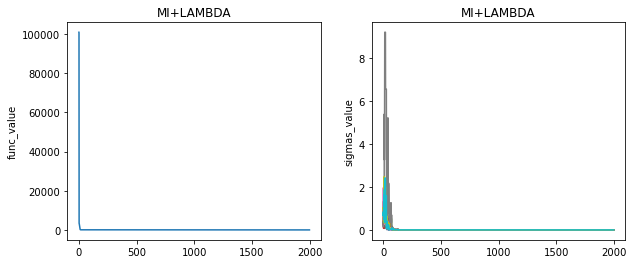

In [945]:
plot_score(g7, 'MI+LAMBDA')
show_res(g7, G7, errg7, s = 1)

# G8, n = 2
The global minima: x∗ = (1.2279713, 4.2453733) , f (x∗) = 0.095825.

In [906]:
penalty = 1e3
epsilon = 1e-10
domain = (0, 10)
g8 = ES(G8, domain, 2, 10000, 10000, 2000, 0.9, verbose = True)

MI+LAMBDA best_score:-0.09582504141709038
Found minima: [1.22797135 4.24537337]
Constraints: (-1.7374597233433144, -0.16776326373037947)
Value of this point: 0.09582504141709038


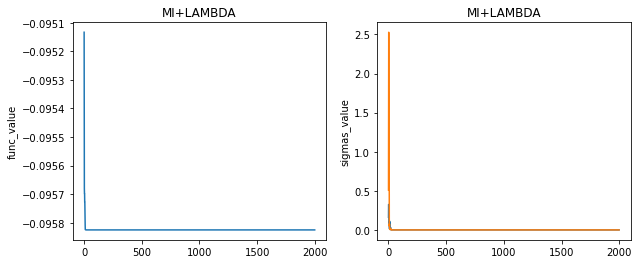

In [907]:
plot_score(g8, 'MI+LAMBDA')
show_res(g8, G8, errg8, s = -1)

# G9, n = 7
The global minima: x∗ = (2.330499, 1.951372,−0.4775414, 4.365726,−0.6244870, 1.038131,1.594227), f (x∗) = 680.6300573.

In [908]:
penalty = 1e4
epsilon = 1e-10
domain = (-10, 10)
g9 = ES(G9, domain, 7, 10000, 10000, 2000, 0.9, verbose = True)

MI+LAMBDA best_score:680.6470702492505
Found minima: [ 2.33076651  1.94201977 -0.50095917  4.38827739 -0.61263933  1.04461568
  1.60428596]
Constraints: (-3.3220634433666305, -252.34805751648594, -144.90788560546477, -6.644126886833323)
Value of this point: 680.6470702492505


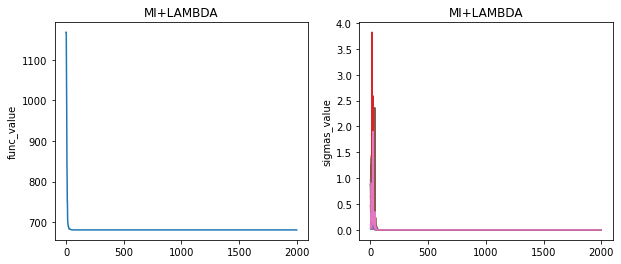

In [909]:
plot_score(g9, 'MI+LAMBDA')
show_res(g9, G9, errg9, s = 1)

# G11, 2
The global minima: x* =  ±(1/20.5, 1/2), f(x*) = 0.75.

In [917]:
penalty = 1e2
epsilon = 1e-5
domain = (-1, 1)
g11 = ES(G11, domain, 2, 10000, 10000, 2000, 0.9, verbose = True)

MI+LAMBDA best_score:0.7500079482812719
Found minima: [-0.70740617  0.50041571]
Constraints: -7.77546829011655e-06
Value of this point: 0.7500079482812719


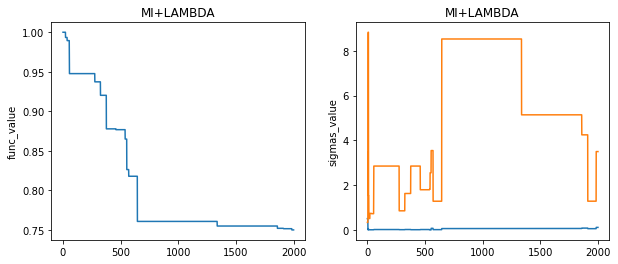

In [918]:
plot_score(g11, 'MI+LAMBDA')
show_res(g11, G11, errg11, s = 1)

# Zadanie 3

In [1057]:
def griewank_mod(y):
    x = A @ y.T + b
    x = x.T
    fr = 4000
    S = np.sum(x * x, axis = 1) / fr
    
    P = np.sqrt(range(1,x.shape[1] + 1)).reshape(1, -1)
    P = np.cos(x / P)
    P = np.prod(P, axis = 1)
    
    return S - P + 1

In [1058]:
def rastrigin_mod(y):
    x = A @ y.T + b
    x = x.T
    n = x.shape[1]
    S = x * x - 10 * np.cos(np.pi * 2 * x)
    S = np.sum(S, axis = 1)
    return 10 * n + S

In [1059]:
def rosenbrock_mod(y):
    x = A @ y.T + b
    x = x.T
    x_j = x[:, :-1]
    x_j1 = x[:, 1:]
    S = 100 * (x_j*x_j - x_j1) ** 2 + (x_j - 1) ** 2
    return np.sum(S, axis = 1)

In [1060]:
def schwefel_mod(y):
    x = A @ y.T + b
    x = x.T
    alpha = 418.9829
    n = x.shape[1]
    S = x * np.sin(np.sqrt(abs(x)))
    return alpha * n - np.sum(S, axis = 1)

In [1061]:
def sphere_mod(y):
    x = A @ y.T + b
    x = x.T
    S = np.sum(x * x, axis = 1)
    return S

In [1062]:
d = 5
h = 10 * d

In [1063]:
A = np.random.uniform(low = 0, high = 1, size = (d,h))

Ay + b = min

Ay = min - b

y = A-1 (min - b) -> czyli znajdujac min G znajdujemy rozwiazanie takiego rownania

Zalozenia:

A - ustalone, ma wartosc [0,1]

y - znajdujemy, ustalamy dziedzine [0,1]

b - dostosowujemy do problemu, tak aby pozostać w dziedzinie

gdy H < domain[1]
b <= domain[1]  - h


In [1115]:
domain = (-5, 10)
b = np.random.uniform(low = domain[0], high = domain[1] - h, size = (d,1))
ros_mod_50 = ES(rosenbrock_mod, (0,1), 50, 2000, 4000, 1000, 1, method = 'mi+lambda', verbose = True)

MI+LAMBDA best_score:356.5386952179011
MI+LAMBDA_mod best_score:1348864.6806164696
[[0.48111503 1.         0.86287813 0.61299321 1.         0.
  0.         0.50963028 0.93204378 0.50101154 0.13966558 0.
  1.         0.35028874 0.78905973 0.02083646 1.         1.
  1.         0.69106059 0.48740468 0.86950836 1.         0.96918164
  0.47708201 1.         0.6535263  1.         1.         0.7186212
  0.         0.53099582 1.         1.         0.80901058 0.77884433
  0.         1.         0.69069755 0.07868636 1.         1.
  1.         1.         0.61367161 1.         0.91151194 1.
  1.         0.        ]]
[[17.60687385]
 [19.84122318]
 [16.83694748]
 [20.23112446]
 [16.37189994]]
[[14.1657669 ]
 [15.65048375]
 [16.65526802]
 [18.70096679]
 [12.16804333]]


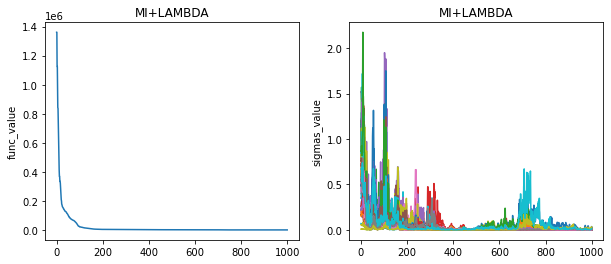

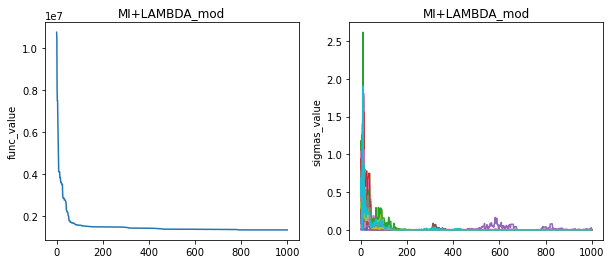

In [1125]:
plot_score(ros_1_50, 'MI+LAMBDA')
plot_score(ros_mod_50, 'MI+LAMBDA_mod')
y = ros_mod_50[2][1].reshape(1,-1)
print(y)
print(A @ y.T)
print(A @ y.T + b)

In [1117]:
domain = (-600, 600)
b = np.random.uniform(low = domain[0], high = domain[1] - h, size = (d,1))
grie_mod_50 = ES(griewank_mod, (0,1), 50, 3000, 4000, 1000, 1.0, method = 'mi+lambda', verbose = True)

MI+LAMBDA best_score:1.8240884205813694
MI+LAMBDA_MOD best_score:256.5357660236482
[[0.         1.         0.40736499 1.         1.         1.
  0.24514721 0.         1.         0.         1.         0.08466077
  1.         0.         0.21714187 1.         0.94969489 0.
  0.42278137 0.16217505 0.07929398 0.83266551 0.74898257 0.14598646
  0.78655111 0.19648214 0.33110562 1.         1.         1.
  1.         0.         0.35094836 1.         0.         0.46546484
  1.         0.03385574 1.         1.         0.65832965 1.
  0.13573102 0.12956413 1.         1.         0.09659516 0.98747851
  0.28516632 1.        ]]
[[13.4432918 ]
 [16.80405524]
 [15.457678  ]
 [14.20634018]
 [14.56587117]]
[[ 560.15525288]
 [-501.43834126]
 [ -41.25377603]
 [ 405.15695958]
 [-547.38536298]]


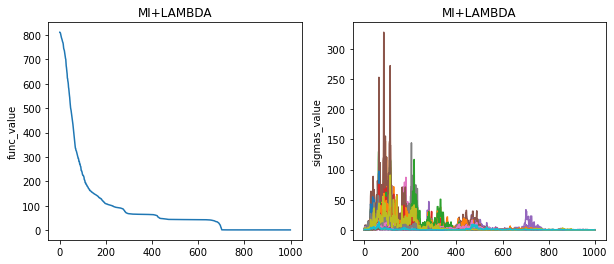

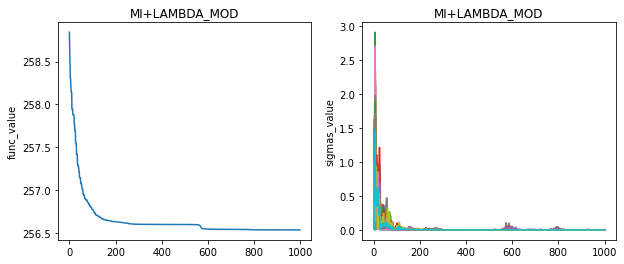

In [1118]:
plot_score(grie_1_50, "MI+LAMBDA")
plot_score(grie_mod_50, 'MI+LAMBDA_MOD')
y = grie_mod_50[2][1].reshape(1,-1)
print(y)
print(A @ y.T)
print(A @ y.T + b)

In [1119]:
domain = (-500, 500)
b = np.random.uniform(low = domain[0], high = domain[1] - h, size = (d,1))
schwe_mod_50 = ES(schwefel_mod, (0,1), 50, 2000, 6000, 1000, 1, method = 'mi+lambda', verbose = True)

MI+LAMBDA best_score:8319.503152009398
MI+LAMBDA_MOD best_score:1583.227889618281
[[0.10861291 0.         0.8193948  0.         0.         0.94016117
  0.48883354 0.07479643 1.         0.42550839 0.         0.3939466
  0.86390191 0.4044781  0.07859241 1.         0.92451446 0.02669929
  0.41340052 0.53539438 0.         0.2290162  0.50523251 0.27285645
  0.43366238 0.8615204  0.27880346 0.3799086  0.68538908 0.88023453
  0.04430675 1.         0.27053949 0.12047178 0.41432167 0.20938707
  0.8919479  0.         1.         0.76885029 0.91136326 0.54743691
  0.         0.         0.38511344 0.99593053 0.93987118 0.13832135
  1.         0.95381621]]
[[ 9.18057344]
 [11.95748201]
 [12.51679398]
 [11.91945007]
 [11.79974602]]
[[-271.97911984]
 [ 436.7565388 ]
 [ 165.23338942]
 [ 268.4527208 ]
 [-353.2811451 ]]


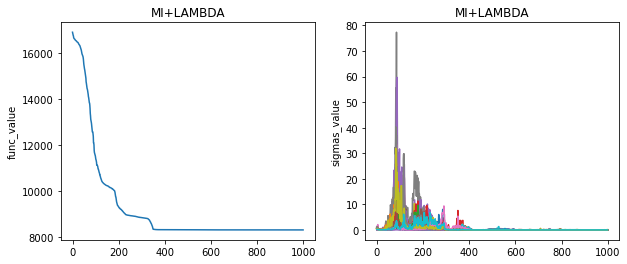

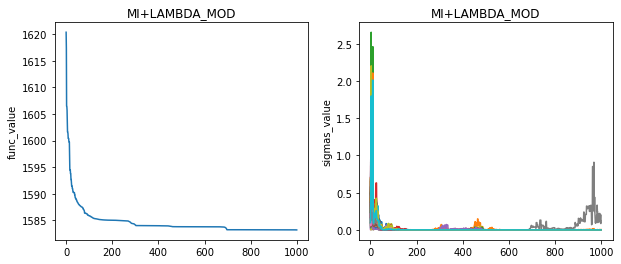

In [1120]:
plot_score(schwe_1_50, "MI+LAMBDA")
plot_score(schwe_mod_50, 'MI+LAMBDA_MOD')
y = schwe_mod_50[2][1].reshape(1,-1)
print(y)
print(A @ y.T)
print(A @ y.T + b)

In [1121]:
domain = (-5.12, 5.12)
b = np.random.uniform(low = domain[0], high = 5 - domain[1] , size = (d,1))
sph_mod_50 = ES(sphere_mod, (0,1/10), 50, 2000, 6000, 1000, 1, method = 'mi+lambda', verbose = True)

MI+LAMBDA best_score:0.6280621770164594
MI+LAMBDA_MOD best_score:14.719488732936254
[[0.1        0.1        0.1        0.1        0.1        0.
  0.09937024 0.1        0.1        0.1        0.1        0.1
  0.1        0.0731151  0.         0.1        0.         0.
  0.1        0.06014813 0.1        0.         0.1        0.
  0.1        0.1        0.1        0.         0.05683718 0.1
  0.09754095 0.1        0.         0.1        0.1        0.1
  0.1        0.1        0.         0.         0.1        0.1
  0.05876015 0.         0.1        0.1        0.         0.1
  0.1        0.1       ]]
[[1.9769938 ]
 [1.91646749]
 [1.92084296]
 [2.00095064]
 [1.70169173]]
[[-2.97518727]
 [-1.46083877]
 [-2.40298773]
 [-2.62912975]
 [ 0.34255906]]
[23.78980916]


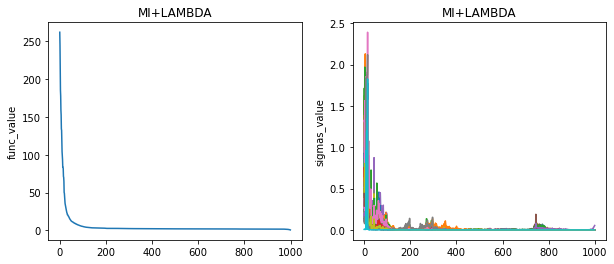

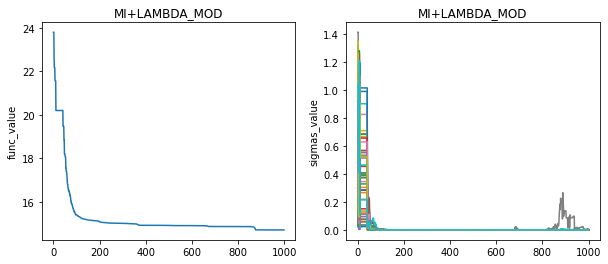

In [1122]:
plot_score(sph_1_50, "MI+LAMBDA")
plot_score(sph_mod_50, 'MI+LAMBDA_MOD')
y = sph_mod_50[2][1].reshape(1,-1)
print(y)
print(A @ y.T)
print(A @ y.T + b)
print(sphere((A @ y.T + b).T))

In [1123]:
domain = (-5.12, 5.12)
b = np.random.uniform(low = domain[0], high = 5 - domain[1], size = (d,1))
rast_mod_50 = ES(rastrigin_mod, (0,1/10), 50, 2000, 6000, 1000, 1, method = 'mi+lambda', verbose = True)

MI+LAMBDA best_score:171.13434989224345
MI+LAMBDA_MOD best_score:22.883992730621394
[[0.1        0.1        0.1        0.1        0.1        0.
  0.         0.1        0.1        0.1        0.         0.1
  0.1        0.         0.         0.         0.         0.1
  0.         0.         0.1        0.         0.         0.1
  0.1        0.         0.         0.         0.         0.
  0.00789233 0.1        0.1        0.1        0.         0.04039676
  0.1        0.1        0.         0.1        0.         0.1
  0.         0.         0.1        0.04165127 0.1        0.
  0.1        0.        ]]
[[1.43622248]
 [1.22276005]
 [1.21230035]
 [1.50467108]
 [1.19561135]]
[[-2.00488447]
 [-2.96797937]
 [ 1.03062089]
 [-0.0254866 ]
 [-3.00824525]]


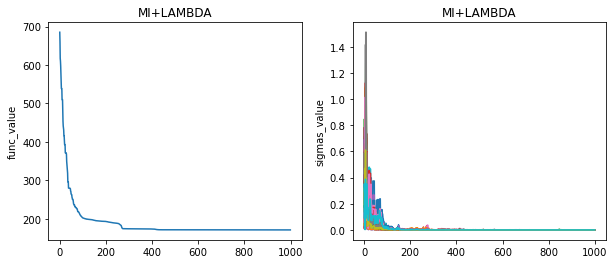

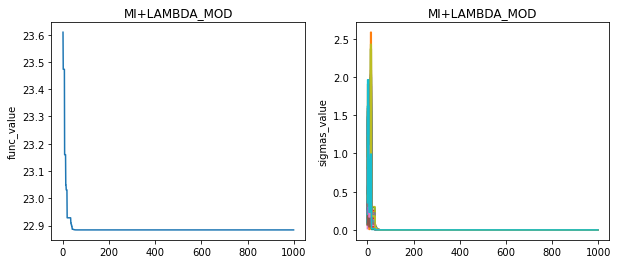

In [1124]:
plot_score(rast_1_50, "MI+LAMBDA")
plot_score(rast_mod_50, 'MI+LAMBDA_MOD')
y = rast_mod_50[2][1].reshape(1,-1)
print(y)
print(A @ y.T)
print(A @ y.T + b)